a) visulization

In [1]:
from MNIST_dataloader import *
from matplotlib import pyplot as plt
import numpy as np

#import os 
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # avoid kernel shutting down

data_loc = 'Datasets' #change the datalocation to something that works for you
batch_size = 64
    
# get dataloader
train_loader, val_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
# get some examples
examples = enumerate(test_loader)
batch_idx, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

In [2]:
print('train:', len(train_loader),'val:', len(val_loader), 'test:', len(test_loader))   

train: 782 val: 157 test: 157


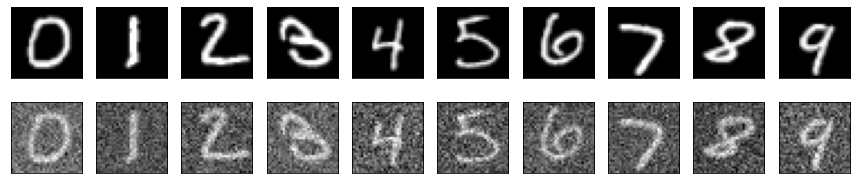

In [3]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [5]:
print('image size =',x_clean_example.size())

image size = torch.Size([64, 1, 32, 32])


b) network

In [4]:
import torch.nn as nn
import torch

dtype = torch.float32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device) # check device type


cuda:0


In [7]:
# model construction
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(32*32,200),
            nn.Linear(200,200),
            nn.Linear(200,10)
        )

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.layer(x)
        return x

In [5]:
# model construction
class Denoise_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(32*32,16*16),
            nn.Linear(16*16,8*8),
            nn.Linear(8*8,4*4),
            nn.Linear(4*4,8*8),
            nn.Linear(8*8,16*16),
            nn.Linear(16*16,32*32),
        )

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.layer(x)
        return x

In [23]:
import torch.optim as optim
import torch.nn.functional as F

# model
def build_model(model):
    model = model
    model.to(device)
    return model

def loss_curve(model,data_loader):

    model.eval()

    loss = 0

    for batch_idx, (clean_, noise_, label_) in enumerate(data_loader):

            if torch.cuda.is_available():
                clean_ = clean_.view(clean_.shape[0],-1).cuda()
                noise_ = noise_.view(clean_.shape[0],-1).cuda()
                label_ = label_.cuda()
            clean_ = clean_.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            noise_ = noise_.to(device=device, dtype=dtype)
            label_ = label_.to(device=device, dtype=torch.long)

            scores = model(noise_)
            loss += criterion(scores,clean_).item()

    return loss / len(data_loader)

# train
def train(model,optimizer,criterion,epochs):

    running_loss = 0.0
    train_loss =[]
    val_loss = []

    for epoch in range(epochs):
        for batch_idx, (clean_, noise_, label_) in enumerate(train_loader):
            model.train()  # put model to training mode
            if torch.cuda.is_available():
                clean_ = clean_.view(clean_.shape[0],-1).cuda()
                noise_ = noise_.view(clean_.shape[0],-1).cuda()
                label_ = label_.cuda()
            clean_ = clean_.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            noise_ = noise_.to(device=device, dtype=dtype)
            label_ = label_.to(device=device, dtype=torch.long)

            scores = model(noise_)
            loss = criterion(scores,clean_)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()   

            running_loss += loss.item()

            # if batch_idx == len(train_loader):
            #      print('[epoch: %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
            #      running_loss = 0.0


        train_loss.append(running_loss/len(train_loader))
        val_loss.append(loss_curve(model,val_loader))
        running_loss = 0

    return train_loss, val_loss
        
                
    # for _, (clean_, noise_, label_) in enumerate(val_loader):
    #     if torch.cuda.is_available():
    #         clean_ = clean_.cuda()
    #         noise_ = noise_.cuda()
    #         label_ = label_.cuda()
    #     outputs = model(noise_)
    #     _, predicted = torch.max(outputs,dim=1)
    #     acc += (label_ == predicted).sum().item()
    #     total += label_.shape[0]
    # print('Val accuracy: %d %%' % (100 * acc / total))

def test(dataloader,model):
    acc = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            clean_, noise_, label_ = data
            if torch.cuda.is_available():
                clean_ = clean_.cuda()
                noise_ = noise_.cuda()
                label_ = label_.cuda()
            outputs = model(noise_)
            _, predicted = torch.max(outputs,dim=1)
            acc += (label_ == predicted).sum().item()
            total += label_.shape[0]
    print('Accuracy: %d %%' % (100 * acc / total))
             

In [24]:
learning_rate = 0.1
autoencoder = build_model(Denoise_autoencoder())
optimizer = optim.SGD(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loss, val_loss = train(autoencoder, optimizer, criterion, 20)

In [92]:
prediction = autoencoder(x_noisy_example.cuda())
prediction = torch.reshape(prediction,(prediction.shape[0],1,32,32)).detach().cpu()

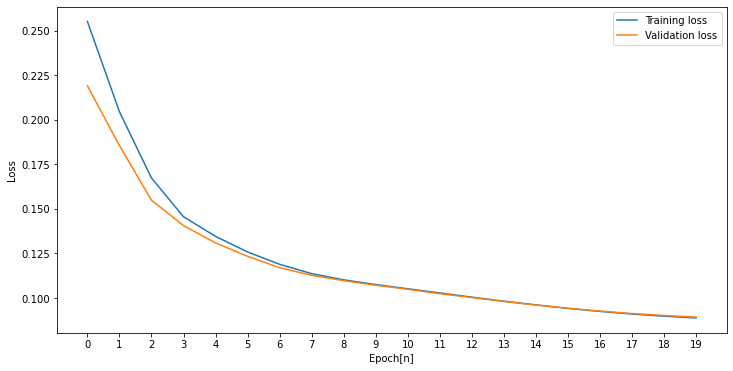

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch[n]')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, 20, 1))
plt.show()

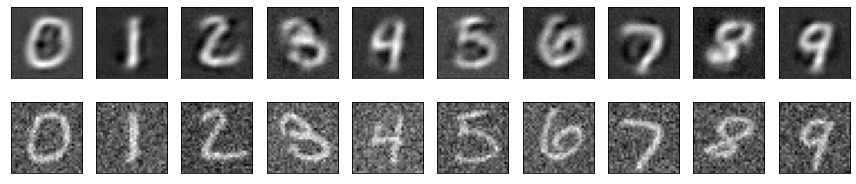

In [93]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(prediction[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

c) activation

In [28]:
def Relu(x):
	a = torch.zeros_like(x)
	return torch.max(x, a)

Text(0, 0.5, 'y')

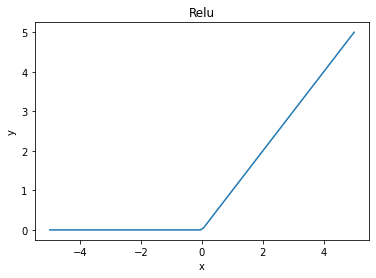

In [95]:
a_x_np = np.linspace(-5,5,100)
a_x = torch.from_numpy(a_x_np)
a_y = Relu(a_x)
plt.plot(a_x,a_y)
plt.title('Relu')
plt.xlabel('x')
plt.ylabel('y')

In [29]:
class Activation(nn.Module):
    def __init__(self):
        super().__init__()
        self.ly1 = nn.Linear(32*32,16*16)
        self.ly2 = nn.Linear(16*16,8*8)
        self.ly3 = nn.Linear(8*8,16*16)
        self.ly4 = nn.Linear(16*16,32*32)    

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.ly1(x)
        x = Relu(x)
        x = self.ly2(x)
        x = Relu(x)
        x = self.ly3(x)
        x = Relu(x)
        x = self.ly4(x)
        return x


In [31]:
learning_rate = 0.01
activation_model = build_model(Activation())
optimizer = optim.Adam(activation_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loss, val_loss = train(activation_model, optimizer, criterion, 20)

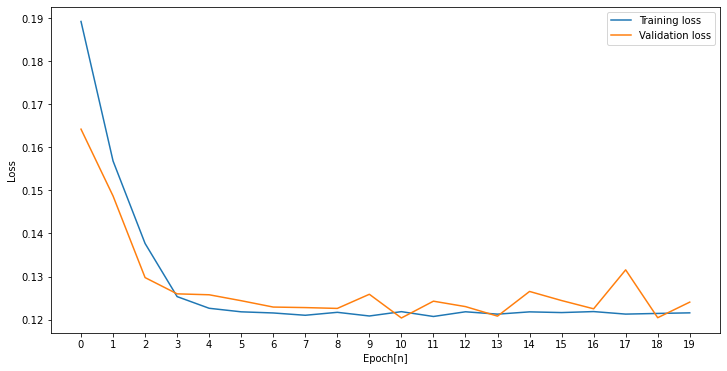

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch[n]')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, 20, 1))
plt.show()

In [108]:
prediction_activation = activation_model(x_noisy_example.cuda())
prediction_activation = torch.reshape(prediction_activation,(prediction_activation.shape[0],1,32,32)).detach().cpu()

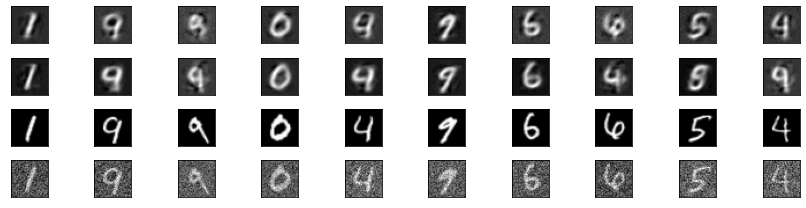

In [112]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(4,10,i+1)
        plt.imshow(prediction[i+15,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])


        plt.subplot(4,10,i+11)
        plt.imshow(prediction_activation[i+15,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(4,10,i+21)
        plt.imshow(x_clean_example[i+15,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(4,10,i+31)
        plt.imshow(x_noisy_example[i+15,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()